In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Downsample all platforms to have the same number of data points


In [64]:
df = pd.read_csv('full_dataset.csv')
df.platform.value_counts()

twitter      488167
reddit        72135
instagram     15652
youtube       11304
Name: platform, dtype: int64

In [65]:
df['positivity_normalized'] = (df.positive_words - df.negative_words)/df.word_count
df['intensity_normalized'] = (df.positive_words + df.negative_words)/df.word_count

In [66]:
df = df.dropna()

In [68]:
df.platform.value_counts()

twitter      488164
reddit        72134
instagram     15044
youtube       11303
Name: platform, dtype: int64

In [69]:
df_twitter = df.loc[df.platform=='twitter'].sample(11303)
df_reddit = df.loc[df.platform=='reddit'].sample(11303)
df_youtube = df.loc[df.platform=='youtube']
df_instagram = df.loc[df.platform=='instagram'].sample(11303)

In [70]:
df_small = pd.concat([df_twitter, df_reddit, df_youtube, df_instagram])

In [79]:
df_small.platform.value_counts()

reddit       11303
twitter      11303
instagram    11303
youtube      11303
Name: platform, dtype: int64

In [71]:
from sklearn.model_selection import train_test_split

In [83]:
df_train, df_test = train_test_split(df_small.copy(), 
                                     shuffle=True, 
                                     test_size=.2, 
                                     random_state=404,
                                    stratify=df_small.platform)

df_test.platform.value_counts()

youtube      2261
instagram    2261
twitter      2261
reddit       2260
Name: platform, dtype: int64

In [84]:
df_train.to_csv('small_train_dataset.csv')
df_test.to_csv('small_test_dataset.csv')

Positivity is the positive_words and negative_words balance.
Intensity is the sum of pos and neg

Unnamed: 0                                               text  \
531834      531834                                           Grandpa?   
325553      325553  The sooner we as an Ummah live in accordance t...   
530669      530669                              High school? College?   
580659      580659         Damn I love this song and this music video   
576082      576082                 He is so messy with the spices lol   

       platform  positive_words  negative_words  length  word_count  \
531834   reddit               0               0       8           1   
325553  twitter               0               0     115          23   
530669   reddit               0               0      21           3   
580659  youtube               1               1      42           9   
576082  youtube               0               1      34           8   

        male_words  female_words  afinn  positivity_normalized  \
531834           0             0    0.0                  0.000   
325553           0             0    2.0                  0.000   
530669           0             0    0.0                  0.000   
580659           0             0    1.0                  0.000   
576082           2             0    3.0                 -0.125   

        intensity_normalized  
531834              0.000000  
325553              0.000000  
530669              0.000000  
580659              0.222222  
576082              0.125000

# Plots

this pairplot takes a while to run


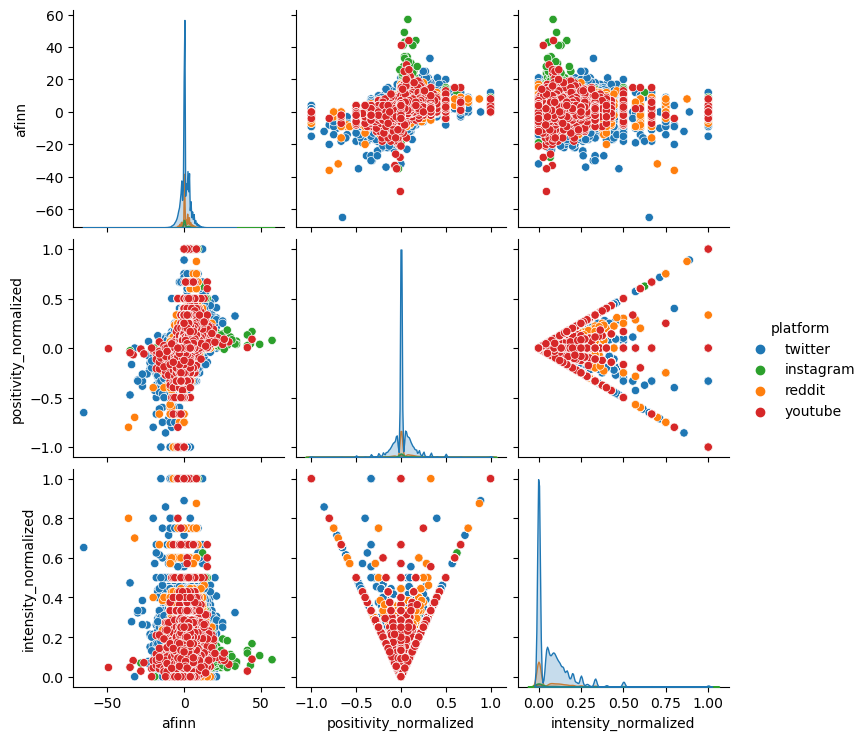

In [96]:
palette = ['tab:blue', 'tab:green', 'tab:orange', 'tab:red']
sns.pairplot(data = df,
            x_vars = ['afinn', 'positivity_normalized', 'intensity_normalized'],
            y_vars = ['afinn', 'positivity_normalized', 'intensity_normalized'], 
            hue='platform',
            palette = palette)

plt.show()

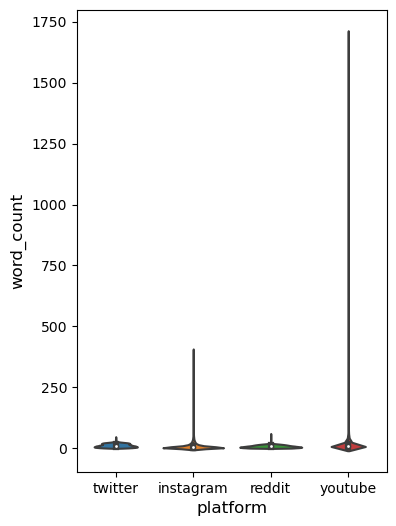

In [91]:
plt.figure(figsize=(4,6))

sns.violinplot(data=df,
               x = 'platform',
               y = 'word_count',
               legend=False)

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.xlabel("platform", fontsize=12)
plt.ylabel("word_count", fontsize=12)

plt.show()

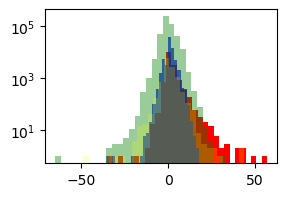

In [68]:
plt.figure(figsize = (3, 2))
plt.hist(df.loc[df.platform_code==0,].afinn, bins = 30, color='red')
plt.hist(df.loc[df.platform_code==1,].afinn, bins = 30, color='blue', alpha=0.7)
plt.hist(df.loc[df.platform_code==2,].afinn, bins = 30, color='green', alpha=0.4)
plt.hist(df.loc[df.platform_code==3,].afinn, bins = 30, color='yellow', alpha=0.2)

plt.yscale('log')
plt.show()

<Axes: xlabel='platform_code', ylabel='intensity'>

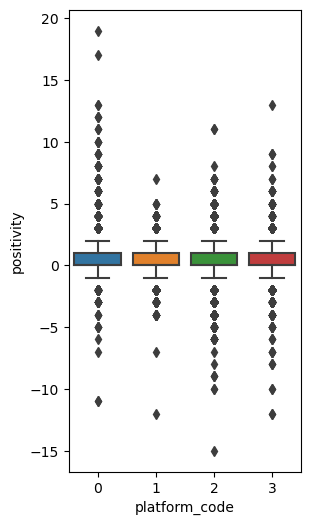

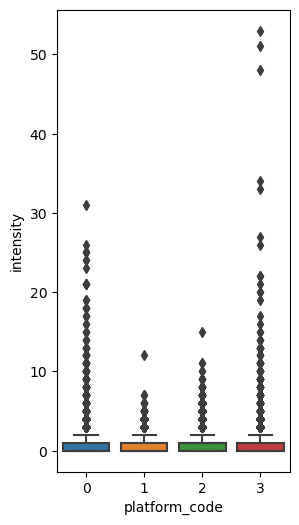

In [93]:
plt.figure(figsize=(3, 6))
sns.boxplot(data=df, y='positivity', x='platform_code')
plt.figure(figsize=(3, 6))
sns.boxplot(data=df, y='intensity', x='platform_code')

<Axes: xlabel='platform_code', ylabel='negative_words'>

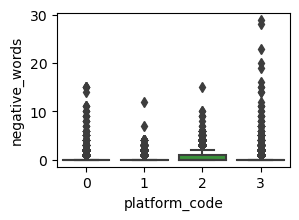

In [71]:
plt.figure(figsize=(3,2))

sns.boxplot(data=df, y='negative_words', x='platform_code')

# single feature logistic regression


In [134]:
from sklearn.linear_model import LogisticRegression 
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split

In [135]:
df_train = pd.read_csv('small_train_dataset.csv')
df_test = pd.read_csv('small_test_dataset.csv')

n_splits = 5
kfold = StratifiedKFold(n_splits, shuffle=True, random_state = 404)
features = ['word_count', 'afinn', 'positivity_normalized', 'intensity_normalized', 'male_words', 'female_words']

## Make your array of zeros to hold the accuracies
log_reg_accs = np.zeros((n_splits, len(features)))

In [136]:
## Loop through the cv splits
i = 0
for train_index, test_index in kfold.split(df_train,df_train.platform):
    ## get the training and holdout sets
    df_tt = df_train.iloc[train_index]
    df_ho = df_train.iloc[test_index]
    
    ## loop through your features
    j = 0
    for feature in features:
        ## Define the model
        log_reg = LogisticRegression(penalty='none')
        
        ## fit the model
        log_reg = log_reg.fit(df_tt[feature].values.reshape(-1, 1), df_tt['platform'].values)
        
        ## Make the prediction
        pred = log_reg.predict(df_ho[feature].values.reshape(-1, 1))
        
        ## Record the accuracy on the holdout set
        log_reg_accs[i,j] = accuracy_score(df_ho['platform'].values, pred)
        print(confusion_matrix(df_ho['platform'].values, pred, labels=["instagram", "twitter", "reddit", "youtube"]))
        j = j + 1
    i = i + 1
    
np.mean(log_reg_accs, axis=0)

[[  75   80 1342  312]
 [ 180  144  754  731]
 [ 192  183 1101  332]
 [ 130  101 1019  558]]
[[ 558 1183    0   68]
 [ 544 1126    0  139]
 [ 557 1118    0  133]
 [ 623 1057    0  128]]
[[ 490 1294   12   13]
 [ 473 1335    0    1]
 [ 462 1345    0    1]
 [ 480 1292   10   26]]
[[ 546    5 1234   24]
 [ 640    2 1146   21]
 [ 579    1 1193   35]
 [ 615    1 1170   22]]
[[   0    0 1700  109]
 [   0    0 1717   92]
 [   0    0 1737   71]
 [   0    0 1642  166]]
[[  95    0 1714    0]
 [  72    0 1737    0]
 [  43    0 1765    0]
 [  51    0 1757    0]]
[[ 111   61 1289  348]
 [ 168  146  765  730]
 [ 197  192 1093  326]
 [ 170   90 1006  542]]
[[ 608 1127    0   74]
 [ 551 1121    0  137]
 [ 564 1114    0  130]
 [ 606 1086    0  116]]
[[ 568 1221   12    8]
 [ 513 1296    0    0]
 [ 442 1366    0    0]
 [ 478 1295   20   15]]
[[ 575    2 1218   14]
 [ 667    2 1108   32]
 [ 587    0 1191   30]
 [ 609    3 1169   27]]
[[   0    0 1704  105]
 [   0    0 1687  122]
 [   0    0 1727   81]
 

array([0.26638837, 0.25085021, 0.25731986, 0.24686893, 0.26265593,
       0.25748572])

In [38]:
print(log_reg_accs)

[[0.282099   0.25269818 0.26522764 0.26125791]
 [0.28312655 0.25173697 0.26215881 0.2617866 ]
 [0.282134   0.24937965 0.25769231 0.26290323]
 [0.2837469  0.24950372 0.25918114 0.26439206]
 [0.27779156 0.25471464 0.26377171 0.26104218]]


# Findings
Original full dataset:

Here we are fitting logistic regression using word_count, afinn, positivity and instensity individually. 
The confusion matrix has true labels on the rows, prediction on the columns. 
Most model just predict all points as twitter. 
The accuracy was high but the model itself is a trivial one. 
It will not generate well. 

We may need to use balance the dataset by undersample twitter data. 

small dataset: 

accuracy for each featuer decrease to about 26%

# combined logistic regression

In [114]:
from sklearn import preprocessing

In [127]:
features = ['word_count', 'afinn', 'positivity_normalized', 'intensity_normalized', 'male_words', 'female_words']
df_train = pd.read_csv('small_train_dataset.csv')
df_test = pd.read_csv('small_test_dataset.csv')

n_splits = 5
kfold = StratifiedKFold(n_splits, shuffle=True, random_state = 404)

## Make your array of zeros to hold the accuracies
log_reg_accs = np.zeros((n_splits, 1))

In [128]:
df_train.head()

Unnamed: 0  Unnamed: 0.1  \
0      261334        261334   
1      519687        519687   
2      504903        504903   
3      500180        500180   
4      493549        493549   

                                                text   platform  \
0                  don't worry someone will get you     twitter   
1              Let me provide some thing for yoooou.     reddit   
2  Most Kanye music and nearly all rap music but ...     reddit   
3  Know who you really are not what people tell y...  instagram   
4                                           Runway.   instagram   

   positive_words  negative_words  length  word_count  male_words  \
0               0               1      34           6           0   
1               0               0      37           7           0   
2               0               1      85          17           0   
3               0               0      59          12           0   
4               0               0       8           1           0   

   female_words  afinn  positivity_normalized  intensity_normalized  
0             0   -3.0              -0.166667              0.166667  
1             0    0.0               0.000000              0.000000  
2             0   -3.0              -0.058824              0.058824  
3             0    0.0               0.000000              0.000000  
4             0    0.0               0.000000              0.000000

In [129]:
scaler = preprocessing.StandardScaler().fit(df_train[features])
df_train_scaled = scaler.transform(df_train[features])

In [132]:
data = {'word_count': df_train_scaled[:, 0],
         'afinn': df_train_scaled[:, 1],
         'positivity_normalized': df_train_scaled[:, 2],
         'intensity_normalized': df_train_scaled[:, 3],
        'male_words': df_train_scaled[:, 4],
        'female_words': df_train_scaled[:, 5],
         'platform': df_train.platform}
df_train = pd.DataFrame(data)

In [133]:
i = 0
for train_index, test_index in kfold.split(df_train, df_train.platform):
    ## get the training and holdout sets

    df_tt = df_train.iloc[train_index]
    df_ho = df_train.iloc[test_index]
    
    ## Define the model
    log_reg = LogisticRegression(penalty='none')
        
    ## fit the model
    log_reg = log_reg.fit(df_tt[features].values, df_tt.platform.values)
        
    ## Make the prediction
    pred = log_reg.predict(df_ho[features].values)
    ## Record the accuracy on the holdout set
    log_reg_accs[i,0] = accuracy_score(df_ho.platform, pred)
    print(confusion_matrix(df_ho.platform, pred, labels=["instagram", "twitter", "reddit", "youtube"]))

    i = i + 1
    
np.mean(log_reg_accs, axis=0)

[[442 184 997 186]
 [400 638 542 229]
 [441 427 823 117]
 [405 341 704 358]]
[[483 158 952 216]
 [401 616 506 286]
 [433 457 790 128]
 [390 358 708 352]]
[[464 210 961 173]
 [422 601 505 280]
 [453 439 801 116]
 [448 367 654 340]]
[[441 198 930 239]
 [397 622 516 273]
 [436 412 844 117]
 [372 414 702 321]]
[[481 164 967 196]
 [399 621 499 289]
 [494 383 828 104]
 [398 385 670 355]]


array([0.31023821])